In [2]:
import sys
from pathlib import Path

# Ensure project root is on sys.path (works from /notebooks)
ROOT = Path.cwd()
if (ROOT / "src").exists():
    sys.path.insert(0, str(ROOT))          # running from project root
else:
    sys.path.insert(0, str(ROOT.parent))   # running from notebooks/

import numpy as np
import tensorflow as tf

from src.config import Config, CLASSES_12
from src.data_io import list_csv_files
from src.preprocess import load_and_clean_csv
from src.sequences import df_to_sequences

np.set_printoptions(suppress=True)

cfg = Config()
np.random.seed(cfg.seed)
tf.random.set_seed(cfg.seed)

class_to_id = {c: i for i, c in enumerate(CLASSES_12)}
num_classes = len(CLASSES_12)

print("Project root:", cfg.project_root)
print("Resolved data dir:", cfg.data_dir)
print("Data dir exists?", cfg.data_dir.exists())


Project root: C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining
Resolved data dir: C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution
Data dir exists? True


In [3]:
all_files = list_csv_files(cfg.data_dir)
print("Found files:", len(all_files))
print(*all_files[:10], sep="\n")

EVAL_BASENAMES = {
    "1hour_sigma0.01.csv",
    "1minute_sigma0.005.csv",
    "1day_sigma0.02.csv",
}

train_files = [f for f in all_files if Path(f).name not in EVAL_BASENAMES]
eval_files  = [f for f in all_files if Path(f).name in EVAL_BASENAMES]

print("\nTrain files:", len(train_files))
print("Eval files:", len(eval_files))
print("Eval picked:", [Path(f).name for f in eval_files])

assert len(eval_files) == len(EVAL_BASENAMES), "Some eval files were not found. Check filenames in data folder."
assert len(train_files) > 0, "Train file list is empty — check data path or eval basenames."


Found files: 18
C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution\1day_sigma0.01.csv
C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution\1day_sigma0.02.csv
C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution\1day_sigma0.05.csv
C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution\1day_sigma0.07.csv
C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution\1day_sigma0.1.csv
C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution\1hour_sigma0.005.csv
C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution\1hour_sigma0.01.csv
C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution\1hour_sigma0.02.csv
C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution\1hour_sigma0.05.csv
C:\Users\bbbal\OneDrive\Masaüstü\dm\data_mining\data\multi_resolution\1minute_sigma0.001.csv

Train files: 15
Eval files: 3
Eval picked: ['1day_sigma0.02.csv', '1hour_sigma0.01.cs

In [4]:
allowed_patterns = set(CLASSES_12) | {"no-pattern"}

test_path = train_files[0]
df = load_and_clean_csv(
    test_path,
    feature_cols=cfg.feature_cols,
    allowed_patterns=allowed_patterns,
    junk_cols=cfg.junk_cols,
    required_cols=cfg.required_cols,
)

X, y = df_to_sequences(
    df,
    feature_cols=cfg.feature_cols,
    seq_len=cfg.seq_len,
    class_to_id=class_to_id,
    min_group_len=cfg.min_group_len,
    max_seqs_per_file=cfg.max_seqs_per_file,
    drop_no_pattern=True,
    pad_value=0.0
)

print(Path(test_path).name)
print("X:", None if X is None else X.shape, "| y:", None if y is None else y.shape)
print(df["pattern"].value_counts().head(10))


1day_sigma0.01.csv
X: (3225, 64, 5) | y: (3225,)
pattern
no-pattern       52277
BearButterfly    11109
BullButterfly     9051
BullGartley       7032
BearShark         7002
BearGartley       6500
BullShark         6148
BullCypher        4825
BullBat           4181
BearCrab          3904
Name: count, dtype: int64


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for path in train_files:
    df = load_and_clean_csv(
        path,
        feature_cols=cfg.feature_cols,
        allowed_patterns=allowed_patterns,
        junk_cols=cfg.junk_cols,
        required_cols=cfg.required_cols,
    )

    X, y = df_to_sequences(
        df,
        feature_cols=cfg.feature_cols,
        seq_len=cfg.seq_len,
        class_to_id=class_to_id,
        min_group_len=cfg.min_group_len,
        max_seqs_per_file=cfg.max_seqs_per_file,
        drop_no_pattern=True,
        pad_value=0.0
    )

    if X is None:
        continue

    Xp = X.reshape(-1, X.shape[-1])
    nonpad = ~(np.all(Xp == 0.0, axis=1))  # ignore padded rows
    if nonpad.any():
        scaler.partial_fit(Xp[nonpad])

def scale_X(X):
    s, t, f = X.shape
    X2 = X.reshape(-1, f)
    X2 = scaler.transform(X2)
    return X2.reshape(s, t, f).astype(np.float32)

In [9]:
from src.models.svm import build_linear_svm

# Flatten sequences for SVM (expects 2D input)
model = build_linear_svm(
    C=1.0,
    max_iter=2000,
    random_state=cfg.seed
)

print("Linear SVM Model initialized")
print("C:", model.C)
print("Multi-class strategy:", model.multi_class)


Linear SVM Model initialized
C: 1.0
Multi-class strategy: ovr


In [10]:
from src.datasets import make_load_xy_fn

load_xy_fn = make_load_xy_fn(
    feature_cols=cfg.feature_cols,
    seq_len=cfg.seq_len,
    class_to_id=class_to_id,
    scaler=scaler,
    junk_cols=cfg.junk_cols,
    required_cols=cfg.required_cols,
    min_group_len=cfg.min_group_len,
    max_seqs_per_file=cfg.max_seqs_per_file,
    drop_no_pattern=True,
    pad_value=0.0,
)

# Load all training data
X_train_list, y_train_list = [], []
for path in train_files:
    X, y = load_xy_fn(path)
    if X is None:
        continue
    X_train_list.append(X)
    y_train_list.append(y)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

print("Training set:", X_train.shape, y_train.shape)

# Flatten sequences for SVM (reshape from (n_samples, seq_len, n_features) to (n_samples, seq_len*n_features))
n_samples, seq_len, n_features = X_train.shape
X_train_flat = X_train.reshape(n_samples, seq_len * n_features)
print("Flattened training set:", X_train_flat.shape)


Training set: (310455, 64, 5) (310455,)
Flattened training set: (310455, 320)


In [ ]:
print("Training Linear SVM...")
model.fit(X_train_flat, y_train)
print("SVM training completed!")

Eval set: (38748, 64, 5) (38748,)
Flattened eval set: (38748, 320)
               precision    recall  f1-score   support

      BearBat       0.10      0.37      0.15      1470
BearButterfly       0.24      0.19      0.21      5495
     BearCrab       0.10      0.26      0.14      1457
   BearCypher       0.10      0.05      0.06      2081
  BearGartley       0.22      0.28      0.25      4979
    BearShark       0.14      0.03      0.05      3933
      BullBat       0.11      0.27      0.16      1658
BullButterfly       0.24      0.09      0.13      5364
     BullCrab       0.13      0.29      0.18      1635
   BullCypher       0.14      0.10      0.11      2176
  BullGartley       0.21      0.22      0.21      4880
    BullShark       0.19      0.03      0.05      3620

     accuracy                           0.16     38748
    macro avg       0.16      0.18      0.14     38748
 weighted avg       0.19      0.16      0.15     38748

Overlap(train, eval) = set()


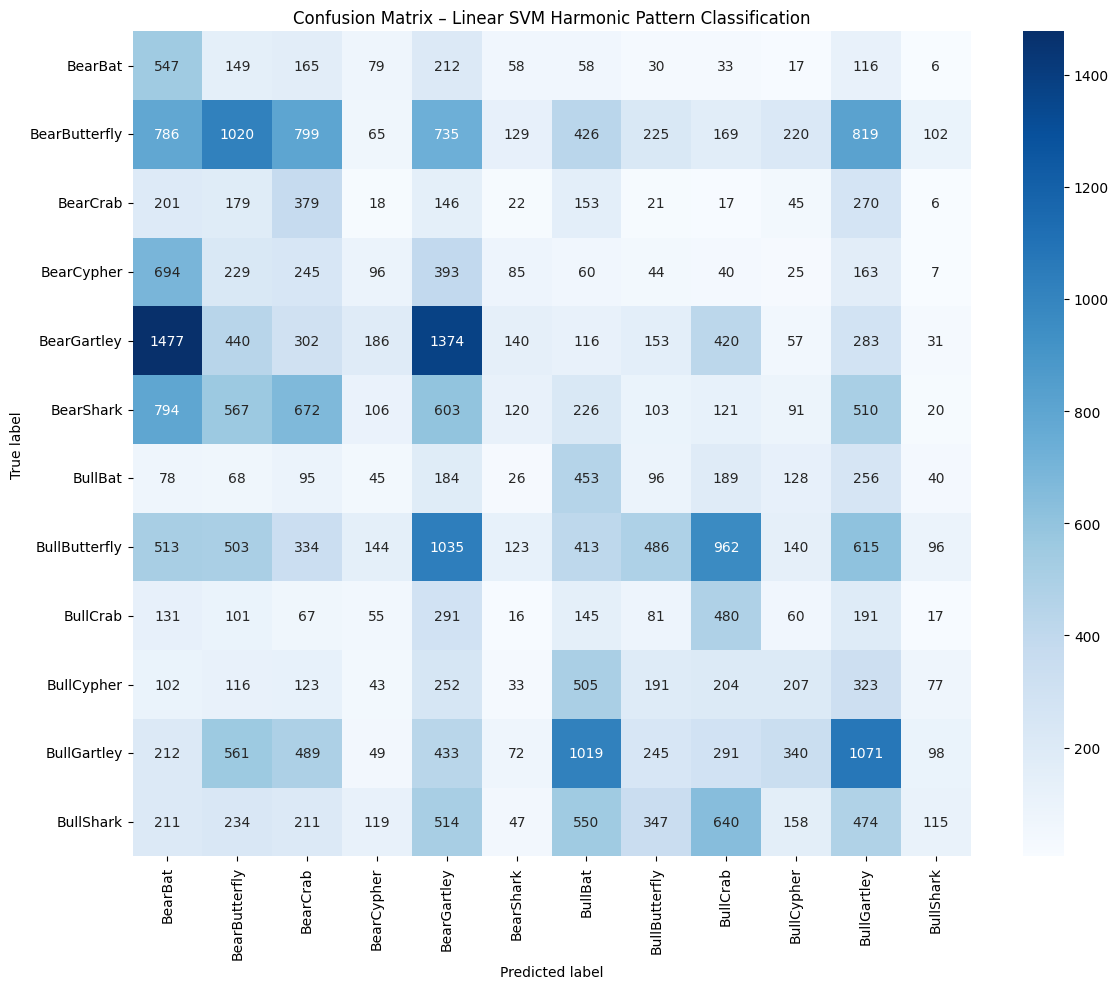

In [13]:
from src.evaluation import (
    build_eval_dataset,
    evaluate_model_multiclass,
    check_train_eval_overlap,
    plot_confusion_matrix
)
from sklearn.metrics import classification_report, confusion_matrix

# Load eval data
X_eval, y_eval = build_eval_dataset(eval_files, load_xy_fn)
print("Eval set:", X_eval.shape, y_eval.shape)

# Flatten eval data for SVM
n_samples_eval, seq_len_eval, n_features_eval = X_eval.shape
X_eval_flat = X_eval.reshape(n_samples_eval, seq_len_eval * n_features_eval)
print("Flattened eval set:", X_eval_flat.shape)

# Make predictions
y_pred = model.predict(X_eval_flat)

# Generate report and confusion matrix
report = classification_report(y_eval, y_pred, target_names=CLASSES_12, digits=2)
cm = confusion_matrix(y_eval, y_pred)

print(report)
print("Overlap(train, eval) =", check_train_eval_overlap(train_files, eval_files))

plot_confusion_matrix(cm, CLASSES_12, "Confusion Matrix – Linear SVM Harmonic Pattern Classification")
